In [1]:
import torch
import torch.distributed as dist
import torch.nn as nn
import torch.optim as optim
import yaml
from torch.nn.parallel import DistributedDataParallel as DDP
import sys, os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributed as dist
import torch.multiprocessing as mp
import torchvision
import torchvision.transforms as transforms
from torch.nn.parallel import DistributedDataParallel
from torch.utils.data import Dataset
import torch.optim as optim
# root_dir = '/mnt/home/spandey/ceph/CHARM/'
# os.chdir(root_dir)
import pickle as pk
import pathlib
curr_path = pathlib.Path().absolute()
src_path = os.path.abspath(curr_path / "../charm/") 
sys.path.append(src_path)
# sys.path.append(root_dir)
# from combined_models import *
# from all_models import *
from charm import *
from utils_data_prep_cosmo_vel import *
from colossus.cosmology import cosmology
params = {'flat': True, 'H0': 67.11, 'Om0': 0.3175, 'Ob0': 0.049, 'sigma8': 0.834, 'ns': 0.9624}
cosmo = cosmology.setCosmology('myCosmo', **params)
from colossus.lss import mass_function
from tqdm import tqdm
import sparse
import numpy as np
import h5py as h5
import torch
from torch.nn import functional as F
from dataclasses import dataclass
from contextlib import nullcontext
from dataclasses import dataclass
from torch.nn.parallel import DistributedDataParallel as DDP
import matplotlib.pyplot as pl

import os
%load_ext autoreload
%autoreload 2
%matplotlib inline




In [3]:
# run_config_name = 'TRAIN_MASS_FREECOSMO_cond_fastpm_ns128.yaml'
run_config_name = 'TRAIN_MASS_FREECOSMO_cond_fastpm_ns128_lresdata.yaml'
with open("/mnt/home/spandey/ceph/CHARM/run_configs/" + run_config_name,"r") as file_object:
    config=yaml.load(file_object,Loader=yaml.SafeLoader)


config_sims = config['sim_settings']
ji_array = np.arange(int(config_sims['nsims']))
nsubvol_per_ji = int(config_sims['nsubvol_per_ji'])
nsubvol_fid = int(config_sims['nsubvol_fid'])
subsel_criteria = config_sims['subsel_criteria']
num_cosmo_params = int(config_sims['num_cosmo_params'])
ns_d = config_sims['ns_d']
# ns_d = 384
nb = config_sims['nb']
nax_d =  ns_d // nb
nf = config_sims['nf']
layers_types = config_sims['layers_types']
z_inference = config_sims['z_inference']
nc = 0
for jl in range(len(layers_types)):
    if layers_types[jl] == 'cnn':
        nc += 1
    elif layers_types[jl] == 'res':
        nc += 2
    else:
        raise ValueError("layer type not supported")

z_all = config_sims['z_all']
z_all_FP = config_sims['z_all_FP']
# z_all_FP = z_all_FP[:-1]
z_all_FP = z_all_FP
ns_h = config_sims['ns_h']
# ns_h = 384
nax_h = ns_h // nb
cond_sim = config_sims['cond_sim']

nsims_per_batch = config_sims['nsims_per_batch']
nbatches_train = config_sims['nbatches_train']

mass_type = config_sims['mass_type']
lgMmin = config_sims['lgMmin']
lgMmax = config_sims['lgMmax']
stype = config_sims['stype']
rescale_sub = config_sims['rescale_sub']
lgMmincutstr = config_sims['lgMmincutstr']
# subsel_highM1 = config_sims['subsel_highM1']
# nsubsel = config_sims['nsubsel']
is_HR = config_sims['is_HR']

try:
    Nmax = config_sims['Nmax']
except:
    Nmax = 4

config_net = config['network_settings']
hidden_dim_MAF = config_net['hidden_dim_MAF']
learning_rate = config_net['learning_rate']
K_M1 = config_net['K_M1']
B_M1 = config_net['B_M1']
nflows_M1_NSF = config_net['nflows_M1_NSF']

K_Mdiff = config_net['K_Mdiff']
B_Mdiff = config_net['B_Mdiff']
nflows_Mdiff_NSF = config_net['nflows_Mdiff_NSF']

base_dist_Ntot = config_net['base_dist_Ntot']
if base_dist_Ntot == 'None':
    base_dist_Ntot = None
base_dist_M1 = config_net['base_dist_M1']
base_dist_Mdiff = config_net['base_dist_Mdiff']
ngauss_M1 = config_net['ngauss_M1']

changelr = config_net['changelr']
ksize = nf
nfeature_cnn = config_net['nfeature_cnn']
nout_cnn = 4 * nfeature_cnn
if cond_sim == 'fastpm':
    if any('v' in str(string) for string in z_all_FP):
        ninp = len(z_all_FP) + 2
    else:
        ninp = len(z_all_FP)

elif cond_sim == 'quijote':
    ninp = len(z_all)
else:
    raise ValueError("cond_sim not supported")

num_cond = nout_cnn + ninp + num_cosmo_params


device_id = torch.device("cuda")
ndim_diff = Nmax - 1

lgM_array = np.linspace(lgMmin, lgMmax, 1000)
M_array = 10**lgM_array
if '200c' in mass_type:
    hmf = mass_function.massFunction(M_array, float(z_inference), mdef = '200c', model = 'tinker08', q_out = 'dndlnM')
if 'vir' in mass_type:
    hmf = mass_function.massFunction(M_array, float(z_inference), mdef = 'vir', model = 'tinker08', q_out = 'dndlnM')    
if 'fof' in mass_type:
    hmf = mass_function.massFunction(M_array, float(z_inference), mdef = 'fof', model = 'bhattacharya11', q_out = 'dndlnM')
lgM_rescaled = rescale_sub + (lgM_array - lgMmin)/(lgMmax-lgMmin)

int_val = sp.integrate.simps(hmf, lgM_rescaled)
hmf_pdf = hmf/int_val
# define the cdf of the halo mass function
hmf_cdf = np.zeros_like(hmf_pdf)
for i in range(len(hmf_cdf)):
    hmf_cdf[i] = sp.integrate.simps(hmf_pdf[:i+1], lgM_rescaled[:i+1])

if 'sigv' in config:
    sigv = config['sigv']
else:
    sigv = 0.05
num_cond_Ntot = num_cond
mu_all = np.arange(Nmax + 1) + 1
sig_all = sigv * np.ones_like(mu_all)
ngauss_Nhalo = Nmax + 1

model_BinaryMask = SumGaussModel(
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_Ntot,
    ngauss=2,
    mu_all=mu_all[:2],
    sig_all=sig_all[:2],
    base_dist=base_dist_Ntot,
    device=device_id
    )

# model_BinaryMask.to(dev)


model_multiclass = SumGaussModel(
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_Ntot,
    ngauss=ngauss_Nhalo - 1,
    mu_all=mu_all[1:] - 1,
    sig_all=sig_all[1:],
    base_dist=base_dist_Ntot,
    device=device_id
    )


# model_multiclass.to(dev)


num_cond_M1 = num_cond + 1
# # if conditioned on fastpm we will also give the fastpm fof M1 halos and its mask as conditional
# if cond_sim == 'fastpm':
#     num_cond_M1 += 2

model_M1 = NSF_1var_CNNcond(
    K=K_M1,
    B=B_M1,
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_M1,
    nflows=nflows_M1_NSF,
    base_dist=base_dist_M1,
    ngauss=ngauss_M1,
    lgM_rs_tointerp=lgM_rescaled,
    hmf_pdf_tointerp=hmf_pdf,
    hmf_cdf_tointerp=hmf_cdf,
    device=device_id 
    )

ndim_diff = Nmax - 1
num_cond_Mdiff = num_cond + 2
model_Mdiff = NSF_Autoreg_CNNcond(
    dim=ndim_diff,
    K=K_Mdiff,
    B=B_Mdiff,
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_Mdiff,
    nflows=nflows_Mdiff_NSF,
    base_dist=base_dist_Mdiff,
    mu_pos=True
    )


ndim = ndim_diff + 1
model = COMBINED_Model(
    None,
    model_Mdiff,
    # None,
    model_M1,
    model_BinaryMask,
    model_multiclass,
    ndim,
    ksize,
    ns_d,
    ns_h,
    1,
    ninp,
    nfeature_cnn,
    nout_cnn,
    layers_types=layers_types,
    act='tanh',
    padding='valid',
    sep_Binary_cond=True,
    sep_MultiClass_cond=True,
    sep_M1_cond=True,
    sep_Mdiff_cond=True,
    num_cond_Binary = num_cond_Ntot,
    num_cond_MultiClass = num_cond_Ntot,
    num_cond_M1 = num_cond_M1,
    num_cond_Mdiff = num_cond_Mdiff
    ).to(device_id)

# model = DDP(model, device_ids=[device_id], find_unused_parameters=True)

model = torch.nn.DataParallel(model)


ldir_cp = '/mnt/home/spandey/ceph/CHARM/model_checkpoints/test0/'

checkpoint = torch.load(ldir_cp + f'test_model_bestfit_6484.pth', map_location=device_id)
# print(iter)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
print()



ldir_f = '/mnt/home/spandey/ceph/Quijote/data_NGP_self/fastpm/3gpc/'

n_dim_red = (nf - 1) // 2
n_pad = n_dim_red * nc

z_REDSHIFT = float(z_all_FP[-1].split('_')[1])
if z_REDSHIFT == 0.0:
    z_REDSHIFT = 0

df_zg = pk.load(open(ldir_f + '%d/density_HR_full_m_res_384_z=0.5_nbatch_8_nfilter_3_ncnn_0.pk'%test_id,'rb'))
df_test_zg = df_zg['density_cic_unpad_combined']
df_load = pk.load(open(
    ldir_f + '/' + str(test_id) + '/velocity_HR_full_m_res_384_z=' + str(z_REDSHIFT) + '_nbatch_8_nfilter_3_ncnn_0.pk', 'rb')
    )

vel_all = df_load['velocity_cic_unpad_combined']

df_test_pad_zg = np.pad(df_test_zg, n_pad, 'wrap')



vel_pad = np.stack([np.pad(vel_all[j,...], n_pad, 'wrap') for j in range(3)], axis=0)

df_test_all_pad = np.concatenate([np.log(1 + df_test_pad_zg + 1e-10)[None,...], vel_pad], axis=0)[None, None,:]
# 
df_test_all_unpad = np.concatenate([np.log(1 + df_test_zg + 1e-10)[None,...], vel_all], axis=0)[None, None,:]




/tmp/ipykernel_4134525/130593235.py:105: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  int_val = sp.integrate.simps(hmf, lgM_rescaled)
/tmp/ipykernel_4134525/130593235.py:110: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  hmf_cdf[i] = sp.integrate.simps(hmf_pdf[:i+1], lgM_rescaled[:i+1])


In [4]:
df_test_all_pad.shape


(1, 1, 4, 392, 392, 392)

In [5]:
def batch_cube(x, Nsub, width, stride):
    """Batches a cube x into Nsub sub-cubes per side, with width and stride."""
    batches = []
    for i in range(Nsub):
        for j in range(Nsub):
            for k in range(Nsub):
                batches.append(x[...,i*stride:i*stride+width,
                                 j*stride:j*stride+width,
                                 k*stride:k*stride+width])
    return np.stack(batches, axis=0)



In [6]:
Nsub = 384 // 128
Npix = 128
Npad = Npix + 2*n_pad
batch_rho = batch_cube(df_test_all_unpad, Nsub, Npix, Npix)
batch_rho_pad = batch_cube(df_test_all_pad, Nsub, Npad, Npix)



In [7]:
def get_halo_mock(df_test_all_pad, df_test_all_unpad):

    cond_nsh_test = np.moveaxis(df_test_all_unpad, 2, 5)
    nsims_test = cond_nsh_test.shape[1]
    nax_h_test = cond_nsh_test.shape[2]
    ninp_test = cond_nsh_test.shape[-1]
    cond_tensor_nsh_test = torch.Tensor(np.copy(cond_nsh_test.reshape(1,nsims_test * (nax_h_test ** 3), ninp_test))).cuda(device_id)    

    # cond_tensor_nsh_test.shape
    # LH_cosmo_val_file='/mnt/home/spandey/ceph/Quijote/latin_hypercube_params.txt'
    # LH_cosmo_val_all = np.loadtxt(LH_cosmo_val_file)
    # fid_cosmo_val_all = LH_cosmo_val_all[test_id]
    fid_cosmo_val_all = np.array([0.3175, 0.049, 0.6711, 0.9624, 0.834])  
    # params = {'flat': True, 'H0': 67.11, 'Om0': 0.3175, 'Ob0': 0.049, 'sigma8': 0.834, 'ns': 0.9624}    

    cosmo_val_test = np.tile(fid_cosmo_val_all, (cond_tensor_nsh_test.shape[1] ,1))[None,:]

    # cosmo_val_test.shape
    # df_test_all_pad.shape, df_test_all_unpad.shape, cosmo_val_test.shape
    df_test_all_pad = torch.tensor(df_test_all_pad).to(device_id)
    df_test_all_unpad = torch.tensor(cond_tensor_nsh_test).to(device_id)
    cosmo_val_test = torch.tensor(cosmo_val_test, dtype=torch.float32).to(device_id)


    train_Ntot, train_M1, train_Mdiff = 1, 1, 1
    train_binary, train_multi = 1, 1
    # if verbose:
        # print(f"Running the model")

    # run the model
    Ntot_samp_test, M1_samp_test, M_diff_samp_test, mask_tensor_M1_samp_test, mask_tensor_Mdiff_samp_test, _ = model.module.inverse(
        cond_x=df_test_all_pad,
        cond_x_nsh=df_test_all_unpad,
        cond_cosmo=cosmo_val_test,
        use_truth_Nhalo=1-train_Ntot,
        use_truth_M1=1-train_M1,
        use_truth_Mdiff=1-train_Mdiff,
        mask_Mdiff_truth=None,
        mask_M1_truth=None,
        Nhalos_truth=None,
        M1_truth=None,
        Mdiff_truth=None,
        train_binary=train_binary,
        train_multi=train_multi,
        train_M1=train_M1,
        train_Mdiff=train_Mdiff,
    )


    BoxSize=1000

    Ntot_samp_test = Ntot_samp_test[0][:, np.newaxis]
    save_subvol_Nhalo = Ntot_samp_test.reshape(
        nsims_test, nax_h_test, nax_h_test, nax_h_test)
    save_subvol_M1 = (M1_samp_test[0] * mask_tensor_M1_samp_test[0][:, 0]
                        ).cpu().detach().numpy().reshape(nsims_test, nax_h_test, nax_h_test, nax_h_test, 1)
    save_subvol_Mdiff = (M_diff_samp_test[0] * mask_tensor_Mdiff_samp_test[0]
                            ).cpu().detach().numpy().reshape(nsims_test, nax_h_test, nax_h_test, nax_h_test, ndim_diff)

    mask_subvol_Mtot1 = mask_tensor_M1_samp_test[0].cpu().detach().numpy().reshape(
        nsims_test, nax_h_test, nax_h_test, nax_h_test)[..., None]
    mask_subvol_Mtot2 = mask_tensor_Mdiff_samp_test[0].cpu().detach().numpy(
    ).reshape(nsims_test, nax_h_test, nax_h_test, nax_h_test, ndim_diff)
    mask_subvol_Mtot = np.concatenate(
        [mask_subvol_Mtot1, mask_subvol_Mtot2], axis=-1)

    # compute the mass of halos from output
    save_subvol_Mtot = np.zeros(
        (nsims_test, nax_h_test, nax_h_test, nax_h_test, ndim_diff + 1))
    # Mmin, Mmax = return_dict_test['Mmin'], return_dict_test['Mmax']
    for jd in range(ndim_diff + 1):
        if jd == 0:
            save_subvol_Mtot[..., jd] = (
                save_subvol_M1[..., 0] + 0.5) * (lgMmax - lgMmin) + lgMmin
        else:
            save_subvol_Mtot[...,
                                jd] = (save_subvol_Mtot[..., jd - 1]) - (save_subvol_Mdiff[..., jd - 1]) * (lgMmax - lgMmin)

    save_subvol_Mtot *= mask_subvol_Mtot

    Nhalos = save_subvol_Nhalo[0, ...]  # histogram of halos in each voxel
    M_halos = save_subvol_Mtot[0, ...]  # mass of halos in each voxel
    M_halos_sort_norm = rescale_sub + (M_halos - lgMmin)/(lgMmax - lgMmin)
    M_halos_sort_norm *= mask_subvol_Mtot[0, ...]
    M_halos_sort_norm_condvel = M_halos_sort_norm.reshape(nax_h_test**3, -1)
    # create the meshgrid
    xall = (np.linspace(0, BoxSize, ns_h + 1))
    xarray = 0.5 * (xall[1:] + xall[:-1])
    yarray = np.copy(xarray)
    zarray = np.copy(xarray)
    x_cy, y_cy, z_cy = np.meshgrid(xarray, yarray, zarray, indexing='ij')

    # record discrete halo positions and masses
    x_h_mock, y_h_mock, z_h_mock, lgM_mock = [], [], [], []
    # Nmax_sel = 3
    k = 0
    for jx in range(ns_h):
        for jy in range(ns_h):
            for jz in range(ns_h):
                Nh_vox = int(Nhalos[jx, jy, jz])
                if Nh_vox > 0:
                    x_h_mock.append(x_cy[jx, jy, jz]*np.ones(Nh_vox))
                    y_h_mock.append(y_cy[jx, jy, jz]*np.ones(Nh_vox))
                    z_h_mock.append(z_cy[jx, jy, jz]*np.ones(Nh_vox))

                    lgM_mock.append((M_halos[jx, jy, jz, :Nh_vox]))
                    k += Nh_vox

    # convert to numpy arrays
    x_h_mock = np.concatenate(x_h_mock)
    y_h_mock = np.concatenate(y_h_mock)
    z_h_mock = np.concatenate(z_h_mock)
    pos_h_mock = np.vstack((x_h_mock, y_h_mock, z_h_mock)).T
    lgMass_mock = np.concatenate(lgM_mock)
    # convert to float data type
    pos_h_mock = pos_h_mock.astype('float32')
    lgMass_mock = lgMass_mock.astype('float32')
    return pos_h_mock, lgMass_mock






In [8]:
hposs_all, lgMass_all = [], []
for i in range(len(batch_rho)):
    hpos, hmass = get_halo_mock(batch_rho_pad[i,...], batch_rho[i,...])
    mask = hmass > 13.7
    hposs_all.append(hpos[mask])
    lgMass_all.append(hmass[mask])

Lcharm = 1000.
l = 0
for i in range(Nsub):
    for j in range(Nsub):
        for k in range(Nsub):
            hposs_all[l] += np.array([i, j, k])*Lcharm
            l += 1

# Combine the outputs
pos_h_mock, lgMass_mock = np.concatenate(hposs_all), np.concatenate(lgMass_all)




/tmp/ipykernel_4134525/970040413.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  df_test_all_unpad = torch.tensor(cond_tensor_nsh_test).to(device_id)


In [18]:
import matplotlib.pyplot as pl
import numpy as np
import Pk_library as PKL
import MAS_library as MASL

def get_Pk_mock(pos_h_mock, lgMass_mock, grid = 384, BoxSize = 3000.0, lgMmin=13.7, MAS='NGP'):
    indsel = np.where(lgMass_mock > (lgMmin))[0]
    pos_h_mock = pos_h_mock[indsel].astype(np.float32)
    lgMass_mock = lgMass_mock[indsel]

    mesh_mock = np.zeros((grid, grid, grid), dtype=np.float32)
    MASL.MA(pos_h_mock, mesh_mock, BoxSize, MAS)
    mesh_mock /= np.mean(mesh_mock, dtype=np.float32);  mesh_mock -= 1.0
    Pk_mock = PKL.Pk(mesh_mock, BoxSize, axis=0, MAS=None)
    return Pk_mock


def get_Pk_quijote(snapdir, snapnum, grid = 384, BoxSize = 3000.0, lgMmin=13.7, MAS='NGP'):
    rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
    with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
        lines = f.readlines()
    header = lines[0].split()
    # get the properties of the halos
    pos_h_truth = rockstar[:,header.index('X'):header.index('Z')+1]
    index_M = header.index('M200c')                    
    mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h
    lgMass_truth = np.log10(mass_truth).astype(np.float32)

    indsel = np.where(mass_truth > 10**(lgMmin))[0]
    pos_h_truth = pos_h_truth[indsel].astype(np.float32)
    lgMass_truth = lgMass_truth[indsel]

    mesh_truth = np.zeros((grid, grid, grid), dtype=np.float32)
    MASL.MA(pos_h_truth, mesh_truth, BoxSize, MAS)
    mesh_truth /= np.mean(mesh_truth, dtype=np.float32);  mesh_truth -= 1.0
    Pk_truth = PKL.Pk(mesh_truth, BoxSize, axis=0, MAS=None)
    return Pk_truth


# Get the power from the mock catalog:
Pk_mock = get_Pk_mock(pos_h_mock, lgMass_mock, grid = 384, BoxSize = 3000.0)


# Get the power from various Quijote simulations:
snapnum = 3
snap_dir_3gpc = '/mnt/home/fvillaescusa/ceph/Quijote/Matt/Sims/fiducial/Rockstar'
Pk_quijote_3gpc = get_Pk_quijote(snap_dir_3gpc, snapnum, grid = 384, BoxSize = 3000.0)

snap_dir_1gpc_HR = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/Rockstar/fiducial_HR/1/'
Pk_quijote_1gpc_HR = get_Pk_quijote(snap_dir_1gpc_HR, snapnum, grid = 128, BoxSize = 1000.0)

snap_dir_1gpc_LR = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/Rockstar/fiducial/1/'
Pk_quijote_1gpc_LR = get_Pk_quijote(snap_dir_1gpc_LR, snapnum, grid = 128, BoxSize = 1000.0)


pl.figure()
pl.plot(Pk_mock.k3D, Pk_mock.Pk[:,0], label='Mock-3Gpc')
pl.plot(Pk_quijote_3gpc.k3D, Pk_quijote_3gpc.Pk[:,0], label='Quijote-LR-3Gpc')
pl.plot(Pk_quijote_1gpc_HR.k3D, Pk_quijote_1gpc_HR.Pk[:,0], label='Quijote-HR-1Gpc')
pl.plot(Pk_quijote_1gpc_LR.k3D, Pk_quijote_1gpc_LR.Pk[:,0], label='Quijote-LR-1Gpc')

pl.xscale('log')
pl.yscale('log')
pl.xlim(0.003, 0.4)
pl.ylim(2e4, 1e7)
pl.legend()
pl.xlabel('k', size=15)
pl.ylabel('P(k)', size=15)







Computing power spectrum of the field...
Time to complete loop = 1.80
Time taken = 2.45 seconds


/tmp/ipykernel_4134525/2342838528.py:27: RuntimeWarning: divide by zero encountered in log10
  lgMass_truth = np.log10(mass_truth).astype(np.float32)



Computing power spectrum of the field...
Time to complete loop = 1.82
Time taken = 2.47 seconds

Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.09 seconds

Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.08 seconds


Text(0, 0.5, 'P(k)')

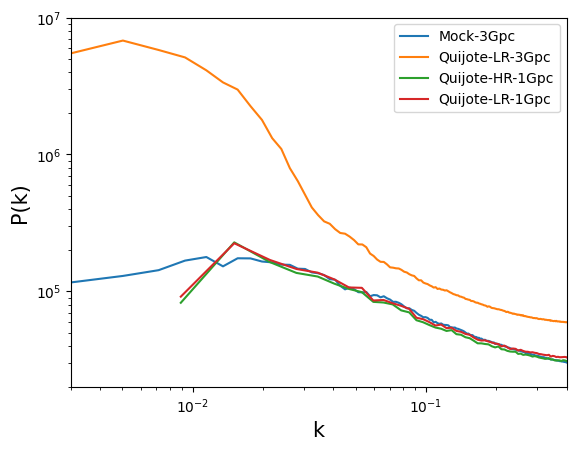

In [119]:

isim = test_id
# snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/Rockstar/fiducial_HR'
snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Matt/Sims/fiducial/Rockstar'
snapnum = 3
MAS     = 'NGP'  #mass-assigment scheme
verbose = False   #print information on progress
snapdir = snap_dir_base  #folder hosting the catalogue
rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
    lines = f.readlines()
header = lines[0].split()
# get the properties of the halos
pos_h_truth = rockstar[:,header.index('X'):header.index('Z')+1]
index_M = header.index('M200c')                    
mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h
lgMass_truth = np.log10(mass_truth).astype(np.float32)
vel_h_truth = rockstar[:,header.index('VX'):header.index('VZ')+1]

indsel = np.where(mass_truth > 10**(13.7))[0]
pos_h_truth_3gpc = pos_h_truth[indsel]
vel_h_truth_3gpc = vel_h_truth[indsel]
lgMass_truth_3gpc = lgMass_truth[indsel]




/tmp/ipykernel_4068901/1458337577.py:16: RuntimeWarning: divide by zero encountered in log10
  lgMass_truth = np.log10(mass_truth).astype(np.float32)


In [120]:

isim = test_id
snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/Rockstar/fiducial_HR/'
# snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Matt/Sims/fiducial/Rockstar'
snapnum = 3
MAS     = 'NGP'  #mass-assigment scheme
verbose = False   #print information on progress
snapdir = snap_dir_base + str(isim)  #folder hosting the catalogue
rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
    lines = f.readlines()
header = lines[0].split()
# get the properties of the halos
pos_h_truth = rockstar[:,header.index('X'):header.index('Z')+1]
index_M = header.index('M200c')                    
mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h
lgMass_truth = np.log10(mass_truth).astype(np.float32)
vel_h_truth = rockstar[:,header.index('VX'):header.index('VZ')+1]

indsel = np.where(mass_truth > 10**(13.7))[0]
pos_h_truth_1gpc = pos_h_truth[indsel]
vel_h_truth_1gpc = vel_h_truth[indsel]
lgMass_truth_1gpc = lgMass_truth[indsel]




/tmp/ipykernel_4068901/3294445083.py:16: RuntimeWarning: divide by zero encountered in log10
  lgMass_truth = np.log10(mass_truth).astype(np.float32)


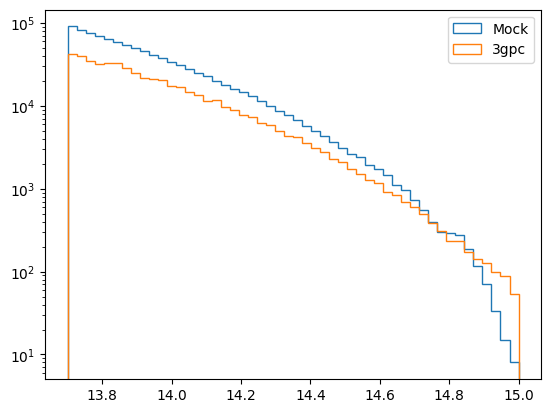

In [121]:
pl.figure()
_ = pl.hist(lgMass_mock, bins=50, histtype='step', label='Mock', range=(13.7, 15.0))
# _ = pl.hist(hmasss[4], bins=50, histtype='step', label='Mock', range=(13.7, 15.5), density=True)
# _ = pl.hist(lgMass_truth_1gpc, bins=50, histtype='step', label='1gpc', range=(13.7, 15.0))
_ = pl.hist(lgMass_truth_3gpc, bins=50, histtype='step', label='3gpc', range=(13.7, 15.0))
pl.legend()
pl.yscale('log')




In [122]:
import Pk_library as PKL
import MAS_library as MASL

grid = 384
sigma_lgM = 0.2
alpha = 0.0
nbar = 4e-4
sat_frac = 0.2
BoxSize = 3000.0 #Mpc/h ; size of box
Mmin_Pk = 13.7
Mmax_Pk = 15.0
threads = 1
M1 = 14.0
MAS = 'NGP'

indsel_Pk_truth = np.where((lgMass_truth_3gpc > Mmin_Pk) & (lgMass_truth_3gpc < Mmax_Pk))[0]
mesh_truth2 = np.zeros((grid, grid, grid), dtype=np.float32)
pos_truth2 = (pos_h_truth_3gpc[indsel_Pk_truth,...]).astype(np.float32)
W_truth = (10**lgMass_truth_3gpc[indsel_Pk_truth]/10**M1)**(alpha)
# MASL.MA(pos_truth2, mesh_truth2, BoxSize, MAS, W=10**((lgMass_truth[indsel_Pk_truth]- Mmax_Pk)))
MASL.MA(pos_truth2, mesh_truth2, BoxSize, MAS, W=W_truth)
mesh_truth2 /= np.mean(mesh_truth2, dtype=np.float64);  mesh_truth2 -= 1.0
Pk_truth2 = PKL.Pk(mesh_truth2, BoxSize, axis=0, MAS=None, threads=threads)

indsel_Pk_mock = np.where((lgMass_mock > Mmin_Pk) & (lgMass_mock < Mmax_Pk))[0]
mesh_mock = np.zeros((grid, grid, grid), dtype=np.float32)
pos_mock = (pos_h_mock[indsel_Pk_mock,...]).astype(np.float32)
W_mock = (10**lgMass_mock[indsel_Pk_mock]/10**M1)**(alpha)
# MASL.MA(pos_mock, mesh_mock, BoxSize, MAS, W=10**((lgMass_mock[indsel_Pk_mock]- Mmax_Pk)))
MASL.MA(pos_mock, mesh_mock, BoxSize, MAS, W=W_mock)
mesh_mock /= np.mean(mesh_mock, dtype=np.float64);  mesh_mock -= 1.0
Pk_mock = PKL.Pk(mesh_mock, BoxSize, axis=0, MAS=None, threads=threads)




Computing power spectrum of the field...
Time to complete loop = 1.80
Time taken = 2.45 seconds

Computing power spectrum of the field...
Time to complete loop = 1.82
Time taken = 2.48 seconds


In [123]:
indsel_Pk_truth = np.where((lgMass_truth_1gpc > Mmin_Pk) & (lgMass_truth_1gpc < Mmax_Pk))[0]
mesh_truth1 = np.zeros((grid//3, grid//3, grid//3), dtype=np.float32)
pos_truth1 = (pos_h_truth_1gpc[indsel_Pk_truth,...]).astype(np.float32)
W_truth = (10**lgMass_truth_1gpc[indsel_Pk_truth]/10**M1)**(alpha)
# MASL.MA(pos_truth2, mesh_truth2, BoxSize, MAS, W=10**((lgMass_truth[indsel_Pk_truth]- Mmax_Pk)))
MASL.MA(pos_truth1, mesh_truth1, BoxSize//3, MAS, W=W_truth)
mesh_truth1 /= np.mean(mesh_truth1, dtype=np.float64);  mesh_truth1 -= 1.0
Pk_truth1 = PKL.Pk(mesh_truth1, BoxSize//3, axis=0, MAS=None, threads=threads)




Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.08 seconds


In [124]:
# len(pos_h_mock), len(pos_h_truth_3gpc), len(pos_h_truth_1gpc)
# 



In [125]:
# pl.figure()
# pl.scatter(pos_h_mock[::100,0], pos_h_mock[::100,1], s=0.4)


In [126]:
# pl.figure()
# pl.scatter(pos_h_truth_3gpc[::100,0], pos_h_truth_3gpc[::100,1], s=0.4)



Text(0, 0.5, 'P(k)')

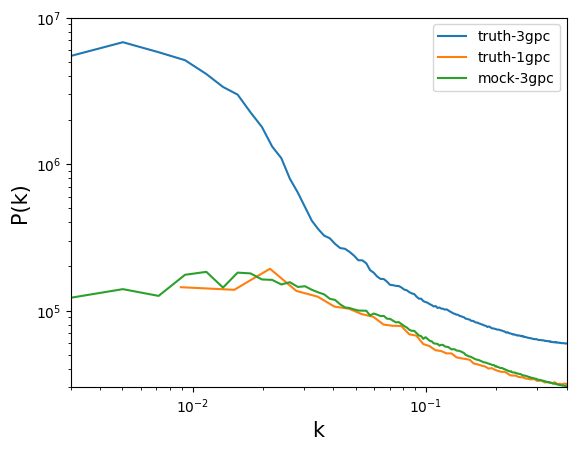

In [137]:
pl.figure()
pl.plot(Pk_truth2.k3D, Pk_truth2.Pk[:,0], label='truth-3gpc')
pl.plot(Pk_truth1.k3D, Pk_truth1.Pk[:,0], label='truth-1gpc')
pl.plot(Pk_mock.k3D, Pk_mock.Pk[:,0], label='mock-3gpc')
pl.xscale('log')
pl.yscale('log')
pl.xlim(0.003, 0.4)
pl.ylim(3e4, 1e7)
pl.legend()
pl.xlabel('k', size=15)
pl.ylabel('P(k)', size=15)


